<a href="https://colab.research.google.com/github/ThaoHuyen1856/BTVN55/blob/main/bt1file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Cài đặt và clone YOLOv5
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


fatal: destination path 'yolov5' already exists and is not an empty directory.
/content/yolov5



image 1/1 /content/1594802172354.jpg: 480x640 3 bowls, 2 broccolis, 1 dining table, 14.3ms
Speed: 4.6ms preprocess, 14.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


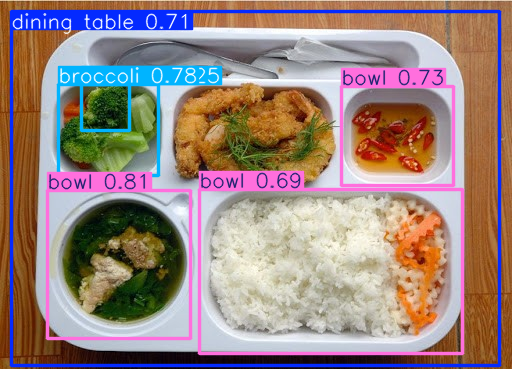

 Đã cắt 6 món ăn và lưu tại: /content/detected_items


In [3]:

!pip install -q ultralytics

from ultralytics import YOLO
import cv2
import os
import matplotlib.pyplot as plt

# LOAD MÔ HÌNH
model = YOLO("yolov8n.pt")  # hoặc thay bằng model đã huấn luyện của bạn

# DỰ ĐOÁN
results = model("/content/1594802172354.jpg")  # ảnh khay cơm

#  HIỂN THỊ BOX
for r in results:
    r.show()

#  CẮT ẢNH VÀ LƯU
output_dir = "/content/detected_items"
os.makedirs(output_dir, exist_ok=True)

img = cv2.imread("/content/1594802172354.jpg")

for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
    x1, y1, x2, y2 = map(int, box)
    crop = img[y1:y2, x1:x2]
    save_path = os.path.join(output_dir, f"item_{i+1}.jpg")
    cv2.imwrite(save_path, crop)

print(f" Đã cắt {len(results[0].boxes)} món ăn và lưu tại: {output_dir}")

In [4]:
import torch
import torch.nn as nn

# ==== 1. Mô hình Dummy CNN rất đơn giản ====
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 224 * 224, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# ==== 2. Khởi tạo và lưu ====
model = SimpleCNN(num_classes=6)
torch.save(model.state_dict(), "cnn_model.pth")
print("Đã tạo xong model dummy: cnn_model.pth")


Đã tạo xong model dummy: cnn_model.pth



image 1/1 /content/1594802172354.jpg: 480x640 3 bowls, 2 broccolis, 1 dining table, 11.5ms
Speed: 4.9ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


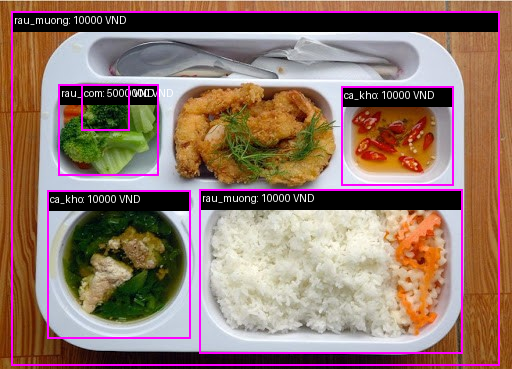


 HÓA ĐƠN PHẦN CƠM 
- ca_kho: 10000 VND
- rau_muong: 10000 VND
- ca_kho: 10000 VND
- rau_muong: 10000 VND
- rau_muong: 10000 VND
- com: 5000 VND
>> TỔNG CỘNG: 55000 VND


In [5]:
#CÀI ĐẶT THƯ VIỆN
!pip install -q ultralytics
import torch
from ultralytics import YOLO
import cv2
import os
import json
from PIL import Image, ImageDraw, ImageFont
import torchvision.transforms as transforms
import torch.nn as nn
from IPython.display import display

#  LOAD MÔ HÌNH
yolo_model = YOLO("yolov8n.pt")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 224 * 224, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.model(x)

with open("/content/drive/MyDrive/canteen_project/class_names.txt", "r", encoding="utf-8") as f:
    class_names = [line.strip() for line in f.readlines()]

with open("/content/drive/MyDrive/canteen_project/menu.json", "r", encoding="utf-8") as f:
    menu = json.load(f)

cnn_model = SimpleCNN(num_classes=len(class_names))
cnn_model.load_state_dict(torch.load("cnn_model.pth", map_location="cpu"))
cnn_model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# ====== DỰ ĐOÁN VÀ VẼ NHÃN ======
image_path = "/content/1594802172354.jpg"
output_dir = "/content/detected_items"
os.makedirs(output_dir, exist_ok=True)

results = yolo_model(image_path)
img_cv = cv2.imread(image_path)
img_pil = Image.open(image_path).convert("RGB")
draw = ImageDraw.Draw(img_pil)

font = ImageFont.load_default()
total_price = 0
receipt = []

for i, box in enumerate(results[0].boxes.xyxy.cpu().numpy()):
    x1, y1, x2, y2 = map(int, box)
    crop = img_cv[y1:y2, x1:x2]
    crop_path = os.path.join(output_dir, f"item_{i+1}.jpg")
    cv2.imwrite(crop_path, crop)

    # Load ảnh cắt và dự đoán bằng CNN
    image_crop = Image.open(crop_path).convert("RGB")
    input_tensor = transform(image_crop).unsqueeze(0)

    with torch.no_grad():
        output = cnn_model(input_tensor)
        pred_idx = output.argmax(dim=1).item()
        pred_class = class_names[pred_idx]

    price = menu.get(pred_class, {}).get("price", 0)
    total_price += price
    receipt.append((pred_class, price))

    # Vẽ nhãn tên món và giá ngay trên ảnh gốc
    label = f"{pred_class}: {price} VND"
    draw.rectangle([x1, y1, x2, y1 + 20], fill="black")
    draw.text((x1 + 3, y1 + 3), label, fill="white", font=font)
    draw.rectangle([x1, y1, x2, y2], outline="magenta", width=2)

# HIỂN THỊ ẢNH GỐC ĐÃ GẮN NHÃN
display(img_pil)

# IN HÓA ĐƠN
print("\n HÓA ĐƠN PHẦN CƠM ")
for name, price in receipt:
    print(f"- {name}: {price} VND")
print(f">> TỔNG CỘNG: {total_price} VND")

# ưLƯU HÓA ĐƠN
with open("receipt.txt", "w", encoding="utf-8") as f:
    f.write(" HÓA ĐƠN PHẦN CƠM \n")
    for name, price in receipt:
        f.write(f"- {name}: {price} VND\n")
    f.write(f">> TỔNG CỘNG: {total_price} VND\n")
